## Домашняя работа по теме "Рекуррентные нейронные сети"

__Задание__ 

Попробуйте изменить параметры нейронной сети, работающей с датасетом imdb, либо нейронной сети, работающей airline-passengers (она прилагается вместе с датасетом к уроку в виде отдельного скрипта) так, чтобы улучшить её точность. Приложите анализ

In [45]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, Flatten
from keras.layers import SimpleRNN, LSTM, GRU
import tensorflow as tf

In [46]:
tf.random.set_seed(1)

Посмотрим на датасет

In [47]:
df = pd.read_csv('airline-passengers.csv', sep=',')
df.head(3)

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


Преобразуем к числам год и месяц

In [49]:
df['Year'] = df['Month'].apply(lambda x: int(x[:4]))
df['Mon'] = df['Month'].apply(lambda x: int(x[-2:]))

In [50]:
df = df.drop(columns='Month')

In [51]:
df.head(3)

,Passengers,Year,Mon
0,112,1949,1
1,118,1949,2
2,132,1949,3


In [52]:
df.describe()

,Passengers,Year,Mon
count,144.000000,144.000000,144.000000
mean,280.298611,1954.500000,6.500000
std,119.966317,3.464102,3.464102
min,104.000000,1949.000000,1.000000
25%,180.000000,1951.750000,3.750000
50%,265.500000,1954.500000,6.500000
75%,360.500000,1957.250000,9.250000
max,622.000000,1960.000000,12.000000


In [53]:
# train/test split

X = df[['Year', 'Mon']]
y = df['Passengers']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.shape, X_test.shape

((96, 2), (48, 2))

In [54]:
#стандартизируем
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Формируем параметры для генерации выборки

In [55]:
# длина истории
x_len = 3

# горизонт предсказания
future = 1

# параметры модели для обучения
learning_rate = 0.001
batch_size = 8
epochs = 10

In [56]:
dataset_train = timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

dataset_test = timeseries_dataset_from_array(
    X_test,
    y_test,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

c:\Users\Полина\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\timeseries_dataset.py:270: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  dataset = tf.data.Dataset.from_tensors(array[start_index:end_index])
c:\Users\Полина\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\timeseries_dataset.py:270: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  dataset = tf.data.Dataset.from_tensors(array[start_index:end_index])


In [57]:
for batch in dataset_train.take(1):
    inputs, targets = batch
    print("Input shape:", inputs.shape)
    print(inputs[1])
    print("Target shape:", targets.shape)
    print(targets[1])

Input shape: (8, 3, 2)
tf.Tensor(
[[-1.3472432   1.52159265]
 [ 0.95717279  0.33881618]
 [-0.19503521  0.33881618]], shape=(3, 2), dtype=float64)
Target shape: (8,)
tf.Tensor(140, shape=(), dtype=int64)


In [58]:
results = pd.DataFrame() # сводная таблица результатов
model = [] # шаг
train_m = [] # результат на трейне
test_m = [] # результат на тесте

**SimpleRNN**

In [59]:
early_stop = EarlyStopping(monitor='val_mae', patience=5)

model_1 = Sequential()

model_1.add(SimpleRNN(32, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model_1.add(Conv1D(64, 3, activation='linear'))
model_1.add(Conv1D(64, 1, activation='linear'))
model_1.add(Flatten())
model_1.add(Dense(3, activation='linear'))
model_1.add(Dense(1, activation='linear'))

model_1.compile(loss='mse', optimizer='adam', metrics=['mae'])
model_1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 3, 32)             1120      
                                                                 
 conv1d_4 (Conv1D)           (None, 1, 64)             6208      
                                                                 
 conv1d_5 (Conv1D)           (None, 1, 64)             4160      
                                                                 
 flatten_2 (Flatten)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 3)                 195       
                                                                 
 dense_6 (Dense)             (None, 1)                 4         
                                                                 
Total params: 11,687
Trainable params: 11,687
Non-trai

In [60]:
history_1 = model_1.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_test,
                    callbacks=[early_stop])

Epoch 1/10
12/12 [==============================] - 2s 38ms/step - loss: 97997.5547 - mae: 287.4734 - val_loss: 79589.4531 - val_mae: 261.7311
Epoch 2/10
12/12 [==============================] - 0s 12ms/step - loss: 97203.7109 - mae: 286.9879 - val_loss: 78847.8047 - val_mae: 261.4365
Epoch 3/10
12/12 [==============================] - 0s 11ms/step - loss: 95518.6094 - mae: 285.9418 - val_loss: 77055.0312 - val_mae: 260.5127
Epoch 4/10
12/12 [==============================] - 0s 11ms/step - loss: 91395.5547 - mae: 282.8540 - val_loss: 72730.0625 - val_mae: 257.2853
Epoch 5/10
12/12 [==============================] - 0s 11ms/step - loss: 82157.5938 - mae: 273.7583 - val_loss: 63722.1289 - val_mae: 246.4169
Epoch 6/10
12/12 [==============================] - 0s 11ms/step - loss: 65194.9102 - mae: 248.9317 - val_loss: 48138.0430 - val_mae: 213.6348
Epoch 7/10
12/12 [==============================] - 0s 11ms/step - loss: 39906.2539 - mae: 188.6429 - val_loss: 23406.9180 - val_mae: 130.5972

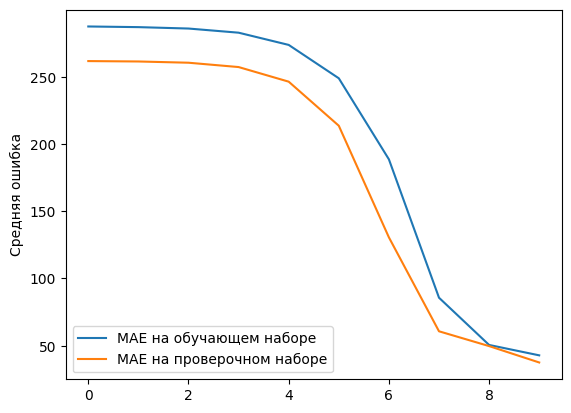

In [61]:
plt.plot(history_1.history['mae'][:], 
         label='MAE на обучающем наборе')
plt.plot(history_1.history['val_mae'][:], 
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [62]:
hist_val_1 = history_1.history['val_mae']
hist_train_1 = history_1.history['mae']

In [63]:
num_iterations = 25

Epoch 1/10
12/12 [==============================] - 0s 12ms/step - loss: 2699.1169 - mae: 37.9347 - val_loss: 2607.1226 - val_mae: 40.7265
Epoch 2/10
12/12 [==============================] - 0s 11ms/step - loss: 2418.4089 - mae: 38.2296 - val_loss: 2446.9709 - val_mae: 40.8210
Epoch 3/10
12/12 [==============================] - 0s 11ms/step - loss: 2309.3477 - mae: 36.5649 - val_loss: 2136.8098 - val_mae: 36.9830
Epoch 4/10
12/12 [==============================] - 0s 12ms/step - loss: 2241.1169 - mae: 35.5651 - val_loss: 2150.5251 - val_mae: 37.1241
Epoch 5/10
12/12 [==============================] - 0s 13ms/step - loss: 2179.3918 - mae: 35.4164 - val_loss: 2147.6213 - val_mae: 37.2358
Epoch 6/10
12/12 [==============================] - 0s 15ms/step - loss: 2126.6270 - mae: 34.8918 - val_loss: 2093.7197 - val_mae: 36.6782
Epoch 7/10
12/12 [==============================] - 0s 11ms/step - loss: 2073.2332 - mae: 34.3847 - val_loss: 2067.4744 - val_mae: 36.4775
Epoch 8/10
12/12 [=========

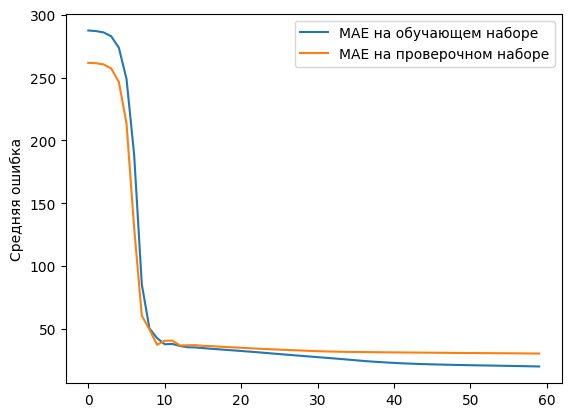

Epoch 1/10
12/12 [==============================] - 0s 13ms/step - loss: 716.3761 - mae: 20.1509 - val_loss: 1611.6724 - val_mae: 30.4896
Epoch 2/10
12/12 [==============================] - 0s 11ms/step - loss: 707.4954 - mae: 20.0380 - val_loss: 1605.1897 - val_mae: 30.4316
Epoch 3/10
12/12 [==============================] - 0s 10ms/step - loss: 698.7458 - mae: 19.9275 - val_loss: 1598.6260 - val_mae: 30.3724
Epoch 4/10
12/12 [==============================] - 0s 12ms/step - loss: 690.1225 - mae: 19.8148 - val_loss: 1592.0146 - val_mae: 30.3120
Epoch 5/10
12/12 [==============================] - 0s 11ms/step - loss: 681.6200 - mae: 19.6999 - val_loss: 1585.3733 - val_mae: 30.2579
Epoch 6/10
12/12 [==============================] - 0s 10ms/step - loss: 673.2356 - mae: 19.5835 - val_loss: 1578.7239 - val_mae: 30.2114
Epoch 7/10
12/12 [==============================] - 0s 13ms/step - loss: 664.9667 - mae: 19.4735 - val_loss: 1572.0811 - val_mae: 30.1637
Epoch 8/10
12/12 [================

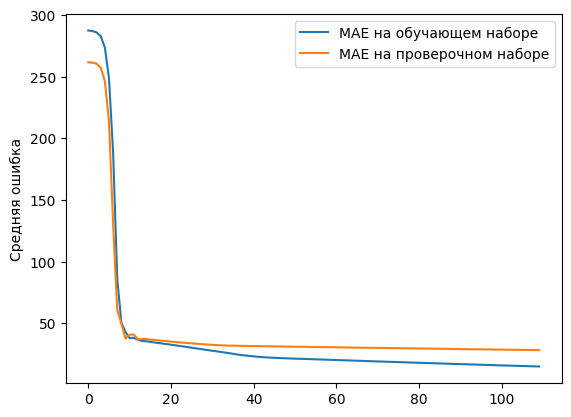

Epoch 1/10
12/12 [==============================] - 0s 11ms/step - loss: 388.0028 - mae: 14.8335 - val_loss: 1291.5844 - val_mae: 28.1684
Epoch 2/10
12/12 [==============================] - 0s 10ms/step - loss: 382.9830 - mae: 14.7423 - val_loss: 1284.6556 - val_mae: 28.1210
Epoch 3/10
12/12 [==============================] - 0s 11ms/step - loss: 378.0042 - mae: 14.6502 - val_loss: 1277.6975 - val_mae: 28.0720
Epoch 4/10
12/12 [==============================] - 0s 11ms/step - loss: 373.0682 - mae: 14.5572 - val_loss: 1270.7104 - val_mae: 28.0214
Epoch 5/10
12/12 [==============================] - 0s 11ms/step - loss: 368.1740 - mae: 14.4634 - val_loss: 1263.6976 - val_mae: 27.9693
Epoch 6/10
12/12 [==============================] - 0s 12ms/step - loss: 363.3231 - mae: 14.3687 - val_loss: 1256.6626 - val_mae: 27.9157
Epoch 7/10
12/12 [==============================] - 0s 11ms/step - loss: 358.5165 - mae: 14.2731 - val_loss: 1249.6064 - val_mae: 27.8607
Epoch 8/10
12/12 [================

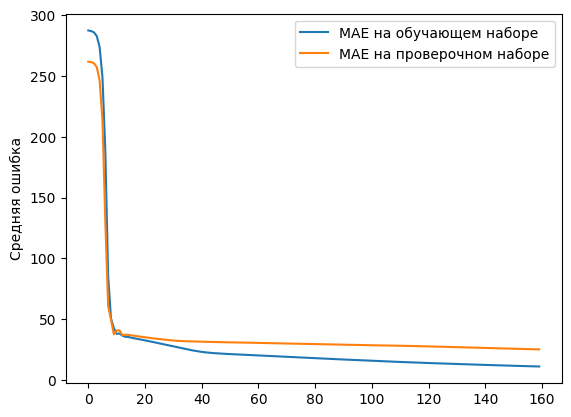

Epoch 1/10
12/12 [==============================] - 0s 12ms/step - loss: 199.5863 - mae: 11.0518 - val_loss: 973.0942 - val_mae: 25.1431
Epoch 2/10
12/12 [==============================] - 0s 11ms/step - loss: 197.2150 - mae: 10.9953 - val_loss: 968.5054 - val_mae: 25.0983
Epoch 3/10
12/12 [==============================] - 0s 10ms/step - loss: 194.8932 - mae: 10.9407 - val_loss: 964.0065 - val_mae: 25.0588
Epoch 4/10
12/12 [==============================] - 0s 11ms/step - loss: 192.6207 - mae: 10.8877 - val_loss: 959.5989 - val_mae: 25.0196
Epoch 5/10
12/12 [==============================] - 0s 11ms/step - loss: 190.3965 - mae: 10.8384 - val_loss: 955.2811 - val_mae: 24.9807
Epoch 6/10
12/12 [==============================] - 0s 11ms/step - loss: 188.2197 - mae: 10.7911 - val_loss: 951.0508 - val_mae: 24.9420
Epoch 7/10
12/12 [==============================] - 0s 11ms/step - loss: 186.0896 - mae: 10.7437 - val_loss: 946.9092 - val_mae: 24.9037
Epoch 8/10
12/12 [=======================

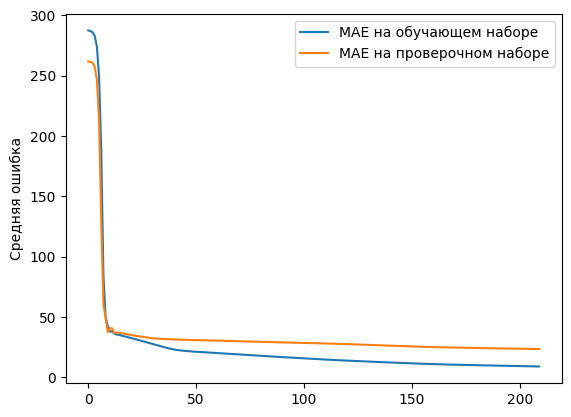

Epoch 1/10
12/12 [==============================] - 0s 12ms/step - loss: 124.3808 - mae: 9.0658 - val_loss: 833.1841 - val_mae: 23.5393
Epoch 2/10
12/12 [==============================] - 0s 12ms/step - loss: 123.4246 - mae: 9.0317 - val_loss: 831.7158 - val_mae: 23.5148
Epoch 3/10
12/12 [==============================] - 0s 12ms/step - loss: 122.4787 - mae: 8.9977 - val_loss: 830.2793 - val_mae: 23.4905
Epoch 4/10
12/12 [==============================] - 0s 12ms/step - loss: 121.5437 - mae: 8.9636 - val_loss: 828.8757 - val_mae: 23.4665
Epoch 5/10
12/12 [==============================] - 0s 11ms/step - loss: 120.6184 - mae: 8.9295 - val_loss: 827.5019 - val_mae: 23.4427
Epoch 6/10
12/12 [==============================] - 0s 10ms/step - loss: 119.7024 - mae: 8.8954 - val_loss: 826.1580 - val_mae: 23.4191
Epoch 7/10
12/12 [==============================] - 0s 11ms/step - loss: 118.7959 - mae: 8.8613 - val_loss: 824.8446 - val_mae: 23.3957
Epoch 8/10
12/12 [==============================

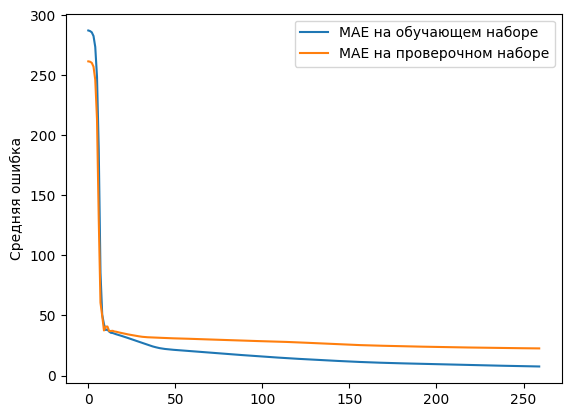

In [64]:
for iteration in range(num_iterations):
  history_1 = model_1.fit(dataset_train,
                      epochs=epochs,
                      validation_data=dataset_test,
                      callbacks=[early_stop])

  hist_val_1.extend(history_1.history['val_mae'][:])
  hist_train_1.extend(history_1.history['mae'][:])

  if (iteration + 1) % 5 == 0:
    plt.plot(hist_train_1, 
            label='MAE на обучающем наборе')
    plt.plot(hist_val_1, 
            label='MAE на проверочном наборе')

    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

Проверяем результаты

In [65]:
pred_1 = model_1.predict(dataset_train).flatten()
pred_val_1 = model_1.predict(dataset_test).flatten()

6/6 [==============================] - 0s 2ms/step


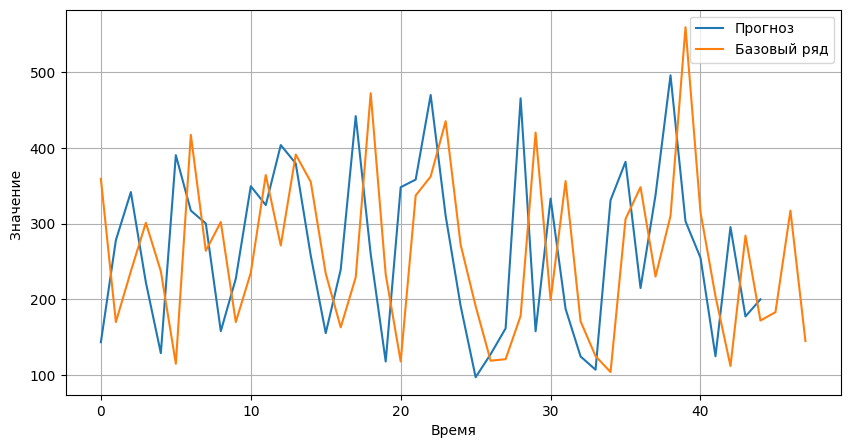

In [66]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val_1[future + start: future + start + step], 
         label='Прогноз')
plt.plot(list(y_test)[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

In [70]:
train_loss_1, train_m_1 = model_1.evaluate(dataset_train)
test_loss_1, test_m_1 = model_1.evaluate(dataset_test)
print(f'train_loss: {train_loss_1}, train_m: {train_m_1}')
print(f'test_loss: {test_loss_1}, test_m: {test_m_1}')

model.append('SimpleRNN')
train_m.append(round(train_m_1,2))
test_m.append(round(test_m_1,2))

6/6 [==============================] - 0s 3ms/step - loss: 789.5645 - mae: 22.5827
train_loss: 76.56914520263672, train_m: 7.171926975250244
test_loss: 789.564453125, test_m: 22.582735061645508


**LSTM**

In [71]:
early_stop = EarlyStopping(monitor='val_mae', patience=5)

model_2 = Sequential()

model_2.add(LSTM(32, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model_2.add(LSTM(32, return_sequences=True))
model_2.add(Conv1D(64, 3, activation='linear'))
model_2.add(Conv1D(64, 1, activation='linear'))
model_2.add(Flatten())
model_2.add(Dense(3, activation='linear'))
model_2.add(Dense(1, activation='linear'))

model_2.compile(loss='mse', optimizer='adam', metrics=['mae'])
model_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 3, 32)             4480      
                                                                 
 lstm_4 (LSTM)               (None, 3, 32)             8320      
                                                                 
 conv1d_6 (Conv1D)           (None, 1, 64)             6208      
                                                                 
 conv1d_7 (Conv1D)           (None, 1, 64)             4160      
                                                                 
 flatten_3 (Flatten)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 3)                 195       
                                                                 
 dense_8 (Dense)             (None, 1)                

In [72]:
history_2 = model_2.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_test,
                    callbacks=[early_stop])

Epoch 1/10
12/12 [==============================] - 6s 97ms/step - loss: 98052.6172 - mae: 287.3441 - val_loss: 79660.3047 - val_mae: 261.3590
Epoch 2/10
12/12 [==============================] - 0s 19ms/step - loss: 97425.2266 - mae: 286.3006 - val_loss: 78630.2031 - val_mae: 259.4762
Epoch 3/10
12/12 [==============================] - 0s 15ms/step - loss: 95211.3750 - mae: 282.6466 - val_loss: 74960.1875 - val_mae: 252.8001
Epoch 4/10
12/12 [==============================] - 0s 13ms/step - loss: 87329.1250 - mae: 269.4362 - val_loss: 62435.2461 - val_mae: 229.0894
Epoch 5/10
12/12 [==============================] - 0s 14ms/step - loss: 62110.8984 - mae: 222.0837 - val_loss: 27804.7031 - val_mae: 146.7098
Epoch 6/10
12/12 [==============================] - 0s 15ms/step - loss: 16493.2734 - mae: 99.0761 - val_loss: 7139.8301 - val_mae: 66.0590
Epoch 7/10
12/12 [==============================] - 0s 15ms/step - loss: 8003.3882 - mae: 73.7862 - val_loss: 3499.8384 - val_mae: 46.7523
Epoch 

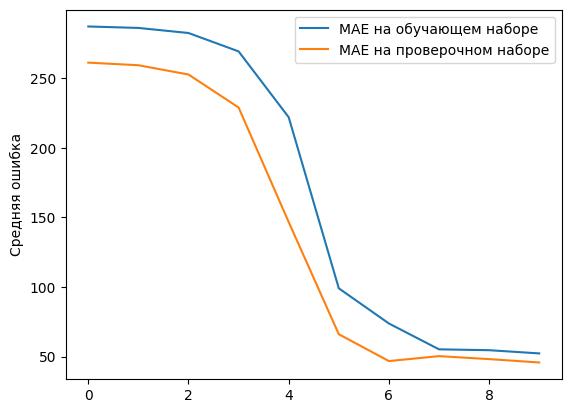

In [73]:
plt.plot(history_2.history['mae'][:], 
         label='MAE на обучающем наборе')
plt.plot(history_2.history['val_mae'][:], 
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [74]:
hist_val_2 = history_2.history['val_mae']
hist_train_2 = history_2.history['mae']

In [75]:
num_iterations = 25

Epoch 1/10
12/12 [==============================] - 0s 17ms/step - loss: 4221.9531 - mae: 50.5849 - val_loss: 3154.5500 - val_mae: 44.4853
Epoch 2/10
12/12 [==============================] - 0s 14ms/step - loss: 4040.9668 - mae: 50.0288 - val_loss: 3060.6389 - val_mae: 43.6123
Epoch 3/10
12/12 [==============================] - 0s 14ms/step - loss: 3883.0481 - mae: 48.5983 - val_loss: 2900.6995 - val_mae: 42.4260
Epoch 4/10
12/12 [==============================] - 0s 13ms/step - loss: 3756.4929 - mae: 47.6750 - val_loss: 2809.5706 - val_mae: 41.6498
Epoch 5/10
12/12 [==============================] - 0s 15ms/step - loss: 3613.1409 - mae: 46.6129 - val_loss: 2698.7156 - val_mae: 40.7095
Epoch 6/10
12/12 [==============================] - 0s 15ms/step - loss: 3483.7104 - mae: 45.5678 - val_loss: 2593.5024 - val_mae: 39.7455
Epoch 7/10
12/12 [==============================] - 0s 15ms/step - loss: 3355.0654 - mae: 44.5954 - val_loss: 2494.4746 - val_mae: 38.7661
Epoch 8/10
12/12 [=========

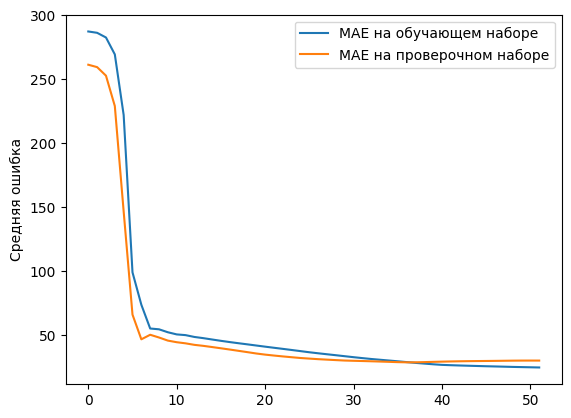

Epoch 1/10
12/12 [==============================] - 0s 15ms/step - loss: 1110.2782 - mae: 24.5828 - val_loss: 1445.1578 - val_mae: 30.1100
Epoch 2/10
12/12 [==============================] - 0s 14ms/step - loss: 1096.6895 - mae: 24.4200 - val_loss: 1444.4608 - val_mae: 30.0686
Epoch 3/10
12/12 [==============================] - 0s 14ms/step - loss: 1083.7448 - mae: 24.2629 - val_loss: 1443.1071 - val_mae: 30.0082
Epoch 4/10
12/12 [==============================] - 0s 16ms/step - loss: 1071.3754 - mae: 24.1043 - val_loss: 1441.2321 - val_mae: 29.9322
Epoch 5/10
12/12 [==============================] - 0s 15ms/step - loss: 1059.5297 - mae: 23.9519 - val_loss: 1438.9644 - val_mae: 29.8438
Epoch 6/10
12/12 [==============================] - 0s 15ms/step - loss: 1048.1683 - mae: 23.8049 - val_loss: 1436.4084 - val_mae: 29.7456
Epoch 7/10
12/12 [==============================] - 0s 15ms/step - loss: 1037.2599 - mae: 23.6610 - val_loss: 1433.6567 - val_mae: 29.6398
Epoch 8/10
12/12 [=========

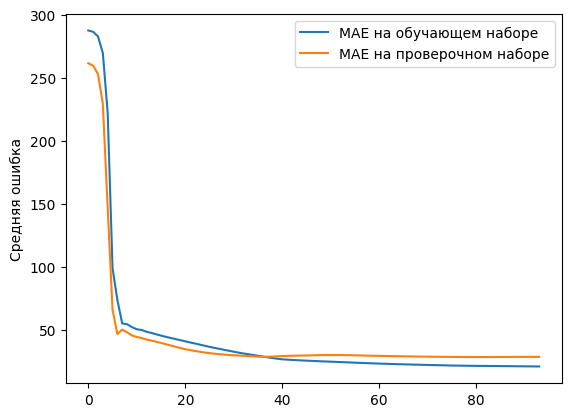

Epoch 1/10
12/12 [==============================] - 0s 14ms/step - loss: 817.0427 - mae: 21.0532 - val_loss: 1356.1908 - val_mae: 28.7174
Epoch 2/10
12/12 [==============================] - 0s 15ms/step - loss: 813.3789 - mae: 21.0139 - val_loss: 1354.3658 - val_mae: 28.7198
Epoch 3/10
12/12 [==============================] - 0s 14ms/step - loss: 809.7752 - mae: 20.9743 - val_loss: 1352.5315 - val_mae: 28.7210
Epoch 4/10
12/12 [==============================] - 0s 15ms/step - loss: 806.2270 - mae: 20.9341 - val_loss: 1350.6876 - val_mae: 28.7211
Epoch 5/10
12/12 [==============================] - 0s 15ms/step - loss: 802.7328 - mae: 20.8937 - val_loss: 1348.8347 - val_mae: 28.7201
Epoch 6/10
12/12 [==============================] - 0s 14ms/step - loss: 799.2900 - mae: 20.8528 - val_loss: 1346.9738 - val_mae: 28.7180
Epoch 1/10
12/12 [==============================] - 0s 15ms/step - loss: 795.8964 - mae: 20.8117 - val_loss: 1345.1019 - val_mae: 28.7149
Epoch 2/10
12/12 [================

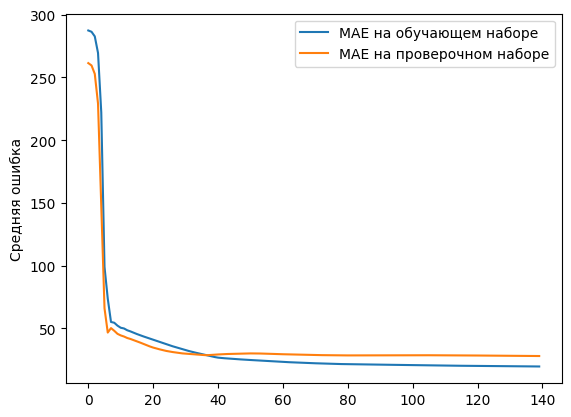

Epoch 1/10
12/12 [==============================] - 0s 15ms/step - loss: 681.9704 - mae: 19.7182 - val_loss: 1263.3424 - val_mae: 28.0506
Epoch 2/10
12/12 [==============================] - 0s 14ms/step - loss: 679.3518 - mae: 19.6925 - val_loss: 1261.1642 - val_mae: 28.0338
Epoch 3/10
12/12 [==============================] - 0s 15ms/step - loss: 676.7347 - mae: 19.6662 - val_loss: 1258.9812 - val_mae: 28.0164
Epoch 4/10
12/12 [==============================] - 0s 14ms/step - loss: 674.1168 - mae: 19.6394 - val_loss: 1256.7921 - val_mae: 27.9986
Epoch 5/10
12/12 [==============================] - 0s 15ms/step - loss: 671.4984 - mae: 19.6120 - val_loss: 1254.6002 - val_mae: 27.9804
Epoch 6/10
12/12 [==============================] - 0s 14ms/step - loss: 668.8788 - mae: 19.5841 - val_loss: 1252.4034 - val_mae: 27.9616
Epoch 7/10
12/12 [==============================] - 0s 14ms/step - loss: 666.2578 - mae: 19.5556 - val_loss: 1250.2036 - val_mae: 27.9424
Epoch 8/10
12/12 [================

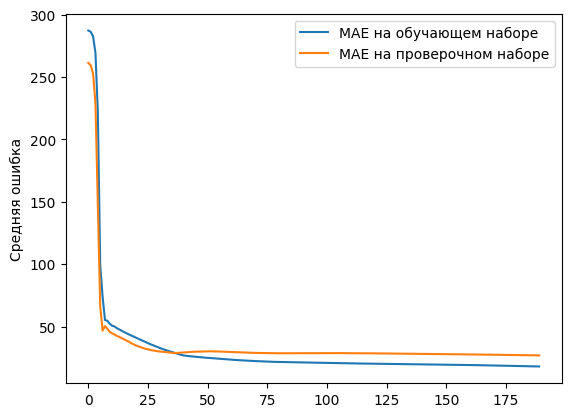

Epoch 1/10
12/12 [==============================] - 0s 15ms/step - loss: 545.1780 - mae: 17.9196 - val_loss: 1151.3550 - val_mae: 26.8457
Epoch 2/10
12/12 [==============================] - 0s 18ms/step - loss: 542.2811 - mae: 17.8759 - val_loss: 1149.1212 - val_mae: 26.8231
Epoch 3/10
12/12 [==============================] - 0s 15ms/step - loss: 539.3815 - mae: 17.8316 - val_loss: 1146.8929 - val_mae: 26.8003
Epoch 4/10
12/12 [==============================] - 0s 14ms/step - loss: 536.4788 - mae: 17.7867 - val_loss: 1144.6685 - val_mae: 26.7771
Epoch 5/10
12/12 [==============================] - 0s 15ms/step - loss: 533.5739 - mae: 17.7412 - val_loss: 1142.4476 - val_mae: 26.7536
Epoch 6/10
12/12 [==============================] - 0s 16ms/step - loss: 530.6662 - mae: 17.6989 - val_loss: 1140.2311 - val_mae: 26.7298
Epoch 7/10
12/12 [==============================] - 0s 15ms/step - loss: 527.7574 - mae: 17.6571 - val_loss: 1138.0211 - val_mae: 26.7057
Epoch 8/10
12/12 [================

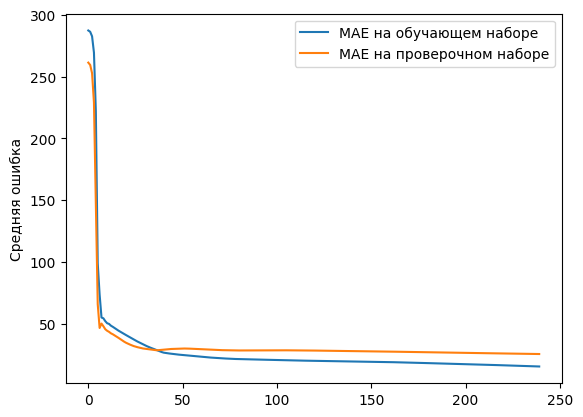

In [76]:
for iteration in range(num_iterations):
  history_2 = model_2.fit(dataset_train,
                      epochs=epochs,
                      validation_data=dataset_test,
                      callbacks=[early_stop])

  hist_val_2.extend(history_2.history['val_mae'][:])
  hist_train_2.extend(history_2.history['mae'][:])

  if (iteration + 1) % 5 == 0:
    plt.plot(hist_train_2, 
            label='MAE на обучающем наборе')
    plt.plot(hist_val_2, 
            label='MAE на проверочном наборе')

    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

Проверяем результаты

In [77]:
pred_2 = model_2.predict(dataset_train).flatten()
pred_val_2 = model_2.predict(dataset_test).flatten()

6/6 [==============================] - 0s 4ms/step


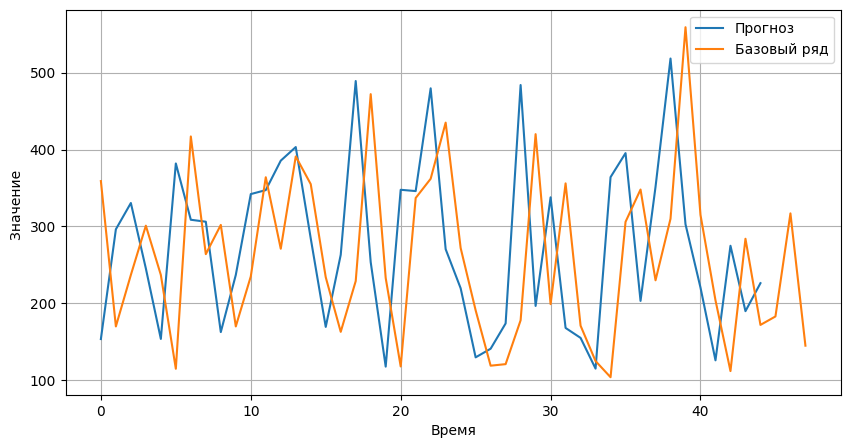

In [78]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val_2[future + start: future + start + step], 
         label='Прогноз')
plt.plot(list(y_test)[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

In [39]:
train_loss_2, train_m_2 = model_2.evaluate(dataset_train)
test_loss_2, test_m_2 = model_2.evaluate(dataset_test)
print(f'train_loss: {train_loss_2}, train_m: {train_m_2}')
print(f'test_loss: {test_loss_2}, test_m: {test_m_2}')

model.append('LSTM')
train_m.append(round(train_m_2,2))
test_m.append(round(test_m_2,2))

6/6 [==============================] - 0s 4ms/step - loss: 6815.3594 - mae: 68.1886
train_loss: 9554.166015625, train_m: 79.59013366699219
test_loss: 6815.359375, test_m: 68.18856811523438


In [79]:
train_loss_2, train_m_2 = model_2.evaluate(dataset_train)
test_loss_2, test_m_2 = model_2.evaluate(dataset_test)
print(f'train_loss: {train_loss_2}, train_m: {train_m_2}')
print(f'test_loss: {test_loss_2}, test_m: {test_m_2}')

model.append('LSTM')
train_m.append(round(train_m_2,2))
test_m.append(round(test_m_2,2))

6/6 [==============================] - 0s 3ms/step - loss: 1051.4553 - mae: 25.6826
train_loss: 384.84442138671875, train_m: 15.317645072937012
test_loss: 1051.455322265625, test_m: 25.68255043029785


In [85]:
results

,model,train_m,test_m
0,SimpleRNN,7.17,22.58
1,LSTM,15.32,25.68


**Выводы:**

* чем больше итераций - тем выше качество
* для данного датасета лучше справился SimpleRNN